In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/hour.csv', encoding='cp949')

/home/idb/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# hour to sine frequency
df['hour_cos'] = np.cos(2*np.pi*df['hr']/24)
df['hour_sin'] = np.sin(2*np.pi*df['hr']/24)

In [3]:
# Data Split
val_split = 0.2
test_split = 0.1

train_df, val_df, test_df = np.split(df, [int((1-test_split-val_split)*len(df)), int((1-test_split)*len(df))])

In [4]:
# Category encoding - Exapanding Mean
cat_enc = dict()
for i in ['season', 'weathersit']:
    cumsum = train_df.groupby(i)['cnt'].cumsum() - train_df['cnt']
    cumcnt = train_df.groupby(i).cumcount() + 1

    # fit & tranform train data
    encoder_df = pd.DataFrame(np.array([train_df[i], cumsum / cumcnt]).T, columns=[i, 'encoding'])
    train_df[i] = encoder_df['encoding']

    # transform valid, test data
    encoder = encoder_df.groupby(i).mean().to_dict('dict')
    cat_enc[i] = encoder # save encoder
    val_df[i] = val_df[i].map(encoder['encoding'])
    test_df[i] = test_df[i].map(encoder['encoding'])

In [5]:
# target : cnt
from sklearn.preprocessing import PowerTransformer
tfm = PowerTransformer()
train_df['cnt_tfm'] = tfm.fit_transform(train_df[['cnt']])
val_df['cnt_tfm'] = tfm.transform(val_df[['cnt']])
test_df['cnt_tfm'] = tfm.transform(test_df[['cnt']])

In [6]:
features = ['hour_cos', 'hour_sin', 'season', 'holiday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt_tfm']

target = ['cnt']

to_scale = ['season', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_df[to_scale] = scaler.fit_transform(train_df[to_scale])
val_df[to_scale] = scaler.transform(val_df[to_scale])
test_df[to_scale] = scaler.transform(test_df[to_scale])

In [7]:
# window data
def window(sequence, n_lookback, n_pred):
    sequence = np.float32(sequence)
    X, y = list(), list()
    for i in range(len(sequence)):
        end_idx = i + n_lookback
        out_end_idx = end_idx + n_pred
        if out_end_idx > len(sequence):
            break
        X.append(sequence[i:end_idx,:-1])
        y.append(sequence[end_idx:out_end_idx, -1])

    X, y = np.array(X), np.array(y)
    if n_pred == 1:
        y = y.reshape(-1,1)

    return X, y

import tensorflow as tf

# to tensorflow dataset
def to_dataset(data, n_lookback, n_pred, batch_size, isTrain):
    X, y = window(data, n_lookback, n_pred)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if isTrain:
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(batch_size)

    return dataset

train_ds = train_df[features+target]
val_ds = val_df[features+target]
test_ds = test_df[features+target]

# set data steps
n_features = len(features)
n_lookback = 24
n_pred = 6
batch_size = 256

# use in Dense Variational
kl_weight = 1/train_ds.shape[0]

train_ds = to_dataset(train_ds, n_lookback, n_pred, batch_size, True)
val_ds = to_dataset(val_ds, n_lookback, n_pred, batch_size, False)
test_ds = to_dataset(test_ds, n_lookback, n_pred, batch_size, False)

2022-07-15 06:00:35.623718: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-15 06:00:35.930439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22095 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, optimizers, losses, metrics, activations, Sequential
tfd = tfp.distributions

# Attention layer (Baswani)
# reference in https://github.com/AmpX-AI/tft-speedup.git

class CustomAttention(layers.Layer):
    def __init__(self, attn_dropout: float = 0.0, **kwargs):
        super().__init__(**kwargs)
        self.dropout = layers.Dropout(attn_dropout)
        self.activation = layers.Activation(tf.nn.softmax)
    
    # tempering attention
    def tempering_batchdot(self, input):
        d, k = input
        temper = tf.sqrt(tf.cast(k.shape[-1], dtype=tf.float32))
        return K.batch_dot(d, k, axes=[2, 2]) / temper

    def __call__(self, q, k, v, mask):
        attn = layers.Lambda(self.tempering_batchdot)([q, k])  # shape=(batch, q, k)
        if mask is not None:
            mmask = layers.Lambda(lambda x: (-1e9) * (1.0 - tf.cast(x, tf.float32)))(mask)  # setting to infinity
            attn = layers.add([attn, mmask])
        attn = self.activation(attn)
        attn = self.dropout(attn)
        output = layers.Lambda(lambda x: K.batch_dot(x[0], x[1]))([attn, v])
        
        return output, attn

# Masking layer (Causal)
class CustomMasking(layers.Layer):
    def __init__(self):
        super().__init__()
    def __call__(self, inputs):
        len_s = tf.shape(inputs)[-2]
        bs = tf.shape(inputs)[:-2]
        mask = tf.cumsum(tf.eye(len_s, batch_shape=bs), -2)

        return mask

# Interpretable Mulit-head Attention
class InterpretableMultiHeadAttention(layers.Layer):
    def __init__(self, n_head: int, dimension: int, n_units: int, dropout: float, **kwargs):
        super().__init__(**kwargs)
        self.n_head = n_head
        self.d_k = self.d_v = d_k = d_v = dimension // n_head
        self.dropout = dropout

        self.qs_layers = []
        self.ks_layers = []
        self.vs_layers = []

        vs_layer = layers.Dense(d_v, use_bias=False)

        for _ in range(n_head):
            self.qs_layers.append(layers.Dense(d_k, use_bias=False))
            self.ks_layers.append(layers.Dense(d_k, use_bias=False))
            self.vs_layers.append(vs_layer)  # use same vs_layer

        self.attention = CustomAttention()
        self.w_o = layers.Dense(n_units, use_bias=False)
    
    def tf_stack(self, x, axis=0):
        if not isinstance(x, list):
            x = [x]
        return K.stack(x, axis=axis)

    def transpose_first_dimensions(self, x, perm_first: list = [1, 0]):
        full_permutation = tf.concat([tf.constant(perm_first), tf.range(tf.rank(x))[len(perm_first) :]], axis=0)
        return tf.transpose(x, full_permutation)
    
    def __call__(self, inputs: list, mask=None):
        q, k, v = inputs[0], inputs[1], inputs[2]
        n_head = self.n_head

        heads = []
        attns = []

        # multi-head attention
        for i in range(n_head):
            qs = self.qs_layers[i](q)
            ks = self.ks_layers[i](k)
            vs = self.vs_layers[i](v)
            
            head, attn = self.attention(qs, ks, vs, mask)

            head_dropout = layers.Dropout(self.dropout)(head)
            heads.append(head_dropout)
            attns.append(attn)

        head = layers.Lambda(self.tf_stack)(heads) if n_head > 1 else heads[0]
        attn = layers.Lambda(self.tf_stack)(attns)

        outputs = layers.Lambda(K.mean, arguments={"axis": 0})(head) if n_head > 1 else head
        outputs = self.w_o(outputs)
        outputs = layers.Dropout(self.dropout)(outputs)  # output dropout

        batched_attentions = layers.Lambda(self.transpose_first_dimensions)(attn)

        return outputs, batched_attentions

# Probabilistic LSTM
class ProbLSTM(models.Model):
    def __init__(self, cell, n_head, n_dim, dropout, n_pred, **kwargs):
        super().__init__()
        self.cell = cell
        self.n_head = n_head
        self.n_dim = n_dim
        self.dropout = dropout
        self.n_pred = n_pred

        self.Layer = layers.LSTM(units = self.cell, return_sequences=True, return_state=True, activation= tf.nn.tanh, dropout=self.dropout)
        self.Interpret = InterpretableMultiHeadAttention(n_head = self.n_head, dimension=self.n_dim, n_units=self.cell, dropout=self.dropout)
        self.Masking = CustomMasking()
        self.Reduced = layers.Lambda(lambda z: K.mean(z, axis=1))
        self.Dropout = layers.Dropout(self.dropout)
        self.ProbDense = layers.Dense(2*self.n_pred) # loc and scale layer
        self.ProbLayer = tfp.layers.DenseVariational(2*self.n_pred , self.posterior_mean_field, self.prior_trainable, kl_weight=kl_weight) # set prior and posterior function

        dist_fn = lambda t: tfd.Normal(loc=t[..., :self.n_pred ],  scale=1e-6 + tf.nn.softplus(t[..., self.n_pred :]))
        self.OutLayer = tfp.layers.DistributionLambda(make_distribution_fn = dist_fn, convert_to_tensor_fn = lambda m: m.mean())

    def posterior_mean_field(self, kernel_size, bias_size=0, dtype=None):
        n = kernel_size + bias_size
        c = np.log(np.expm1(1.))

        return tf.keras.Sequential([
            tfp.layers.VariableLayer(2 * n, dtype=dtype),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(loc=t[..., :n],
                            scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
                ])

    def prior_trainable(self, kernel_size, bias_size=0, dtype=None):
        n = kernel_size + bias_size
        
        return Sequential([
            tfp.layers.VariableLayer(n, dtype=dtype),
            tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1e-3),
                reinterpreted_batch_ndims=1)),
                ])

    def call(self, inputs, initial_state=None):
        x, *state = self.Layer(inputs, initial_state=initial_state)
        x, att_score = self.Interpret([x, x, x], mask = self.Masking(x))
        x = self.Reduced(x)
        x = self.Dropout(x)
        x = self.ProbDense(x)
        x = self.ProbLayer(x)
        outputs = self.OutLayer(x)

        return outputs, att_score
    
def CreatModel(n_lookback, n_features, param):
    model = ProbLSTM(**param)
    model.build(input_shape = (None, n_lookback, n_features))

    return model

# Train class
class Trainer():
    def __init__(self, model, optim, metric):
        self.model = model
        self.optim = optim
        self.metric = metric
        self.n_pred = self.model.n_pred
        
        # to save history
        self.logs = dict()

        # negative loss likelihood
        self.loss_fn = lambda y, rv_y: -tf.reduce_sum(rv_y.log_prob(y))

        optim_dict = {
            'adam' : optimizers.Adam(),
            'Nadam' : optimizers.Nadam()
        }

        metric_dict = {
            'rmse' :  metrics.RootMeanSquaredError(),
            'mape' : metrics.MeanAbsolutePercentageError(),
        }

        self.optimizer = optim_dict[self.optim]
        self.train_metric_fn = metric_dict[self.metric]
        self.val_metric_fn = metric_dict[self.metric]

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            logits, att_score = self.model(x, training = True)
            loss_value = self.loss_fn(y, logits)    
        
        grads = tape.gradient(loss_value, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        self.train_metric_fn.update_state(y, logits)

        return loss_value, att_score

    @tf.function
    def valid_step(self, x, y):
        logits, att_score = self.model(x, training=False)
        loss_value = self.loss_fn(y, logits)

        self.val_metric_fn.update_state(y, logits)

        return loss_value, att_score

    def EarlyStopping(self, monitor, min_delta=0.0, patience=100, mode='min'):
        #No early stopping for the first patience epochs 
        if len(monitor) <= patience:
            return False
        
        min_delta = abs(min_delta)
        if mode == 'min':
            min_delta *= -1
        else:
            min_delta *= 1
        
        # last patience epochs 
        last_patience_epochs = [x + min_delta for x in monitor[::-1][1:patience + 1]]
        current_metric = monitor[::-1][0]
        
        if mode == 'min':
            if current_metric >= max(last_patience_epochs):
                print(f'Metric did not decrease for the last {patience} epochs.')
                return True
            else:
                return False
        else:
            if current_metric <= min(last_patience_epochs):
                print(f'Metric did not increase for the last {patience} epochs.')
                return True
            else:
                return False
    
    def fit(self, train_data, valid_data, epochs, callbacks = 'auto'):
        if callbacks == 'auto':
            callbacks = {'min_delta':0.0, 'patience':100}

        self.logs['train_loss'] = list()
        self.logs['train_metric'] = list()
        self.logs['val_loss'] = list()
        self.logs['val_metric'] = list()
        self.logs['train_attention_score'] = list()
        self.logs['val_attention_score'] = list()

        # train loop
        for epoch in range(epochs):
            batch_train_loss, batch_val_loss = list(), list()
            batch_train_att, batch_val_att = list(), list()

            # batch training
            for _, (X_batch_train, y_batch_train) in enumerate(train_data):
                X_batch_train = tf.cast(X_batch_train, dtype=tf.float32)
                y_batch_train = tf.cast(y_batch_train, dtype=tf.float32)
                
                loss_train_, att_train_ = self.train_step(X_batch_train, y_batch_train)
                batch_train_loss.append(loss_train_)
                batch_train_att.append(att_train_)
            
            loss_train = tf.reduce_mean(batch_train_loss).numpy()
            metric_train = self.train_metric_fn.result().numpy()
            attention_train = tf.concat(batch_train_att, axis=0).numpy()

            self.logs['train_loss'].append(loss_train)
            self.logs['train_metric'].append(metric_train)
            self.logs['train_attention_score'].append(attention_train)

            self.train_metric_fn.reset_states()

            # valid batch
            for _, (X_batch_val, y_batch_val) in enumerate(valid_data):
                X_batch_val = tf.cast(X_batch_val, dtype=tf.float32)
                y_batch_val = tf.cast(y_batch_val, dtype=tf.float32)
                
                loss_valid_, att_valid_ = self.valid_step(X_batch_val, y_batch_val)
                batch_val_loss.append(loss_valid_)
                batch_val_att.append(att_valid_)

            loss_val = tf.reduce_mean(batch_val_loss).numpy()
            metric_val = self.val_metric_fn.result().numpy()
            attention_val = tf.concat(batch_val_att, axis=0).numpy()

            self.logs['val_loss'].append(loss_val)
            self.logs['val_metric'].append(metric_val)
            self.logs['val_attention_score'].append(attention_val)

            self.val_metric_fn.reset_states()
                
            print('Epoch %d | train_loss: %.4f train_metric: %.4f val_loss: %.4f val_metric: %.4f' % (epoch + 1, loss_train, metric_train, loss_val, metric_val))
            stopEarly = self.EarlyStopping(self.logs['val_metric'], min_delta=callbacks['min_delta'], patience=callbacks['patience'])

            if stopEarly:
                print("Terminating training")
                break

        return self.model
    
    def plot(self):
        fig,((ax1,ax2)) = plt.subplots(1,2)
        fig.set_size_inches(15,5)
        ax1.plot(self.logs['train_loss'], label = 'train')
        ax1.plot(self.logs['val_loss'], label = 'valid')
        ax1.set_title('Loss')
        ax1.legend()
        ax2.plot(self.logs['train_metric'], label = 'train')
        ax2.plot(self.logs['val_metric'], label = 'valid')
        ax2.set_title('Metric')
        ax2.legend()
        plt.show()


In [9]:
param = dict(cell= 100, n_head= 2, n_dim= 16, n_pred= n_pred, dropout= 0.2)
model = CreatModel(n_lookback, n_features, param)

2022-07-15 06:00:36.696499: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [10]:
trainer = Trainer(model=model, optim='adam', metric='rmse')
# 확률 모델은 epochs를 크게 설정
model = trainer.fit(train_data=train_ds, valid_data=val_ds, epochs=500, callbacks='auto')

2022-07-15 06:00:38.322078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-07-15 06:00:38.768357: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1 | train_loss: 9072.4961 train_metric: 1.0858 val_loss: 4161.8813 val_metric: 1.0400
Epoch 2 | train_loss: 5147.1753 train_metric: 0.9725 val_loss: 5037.1519 val_metric: 1.0431
Epoch 3 | train_loss: 9897.8398 train_metric: 1.0340 val_loss: 11551.5400 val_metric: 1.1892
Epoch 4 | train_loss: 5529.9219 train_metric: 1.0349 val_loss: 12567.1270 val_metric: 1.0401
Epoch 5 | train_loss: 6001.9097 train_metric: 1.0749 val_loss: 9827.7100 val_metric: 1.0348
Epoch 6 | train_loss: 7177.5601 train_metric: 1.0608 val_loss: 6108.0625 val_metric: 1.0264
Epoch 7 | train_loss: 5075.5298 train_metric: 1.0155 val_loss: 9107.4736 val_metric: 1.1521
Epoch 8 | train_loss: 4464.8340 train_metric: 0.9728 val_loss: 7650.5815 val_metric: 1.0062
Epoch 9 | train_loss: 4445.1509 train_metric: 0.9513 val_loss: 5499.1260 val_metric: 0.9819
Epoch 10 | train_loss: 4245.9707 train_metric: 0.9711 val_loss: 7798.0396 val_metric: 1.0318
Epoch 11 | train_loss: 3963.9949 train_metric: 0.8837 val_loss: 6788.0522 val

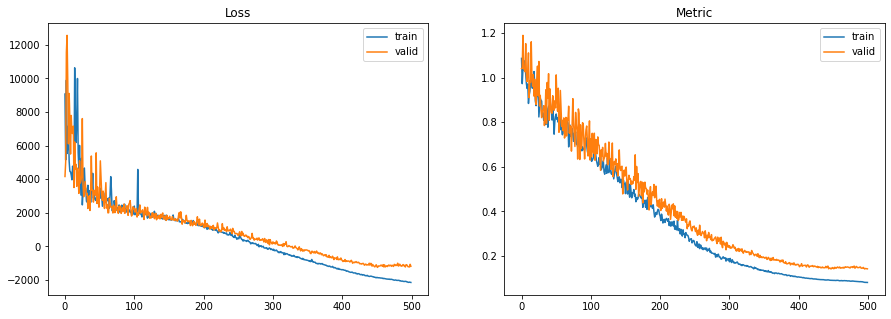

In [11]:
trainer.plot()

In [12]:
# inverse only target data 
def inverse_transform(x):
    array = np.concatenate((np.zeros((len(x), scaler.n_features_in_-1)), x.reshape(-1,1)), axis=1)
    array_transform = scaler.inverse_transform(array)[:,-1]

    return array_transform

# stack inversed data
def get_inv(array):
    return np.stack([inverse_transform(array[:,i]) for i in range(n_pred)], axis=-1)

X_test = np.concatenate([f for f, _ in test_ds])
y_test = np.concatenate([t for _, t in test_ds])

# pred : 확률 분포
# model.predict(X_test) : 모델 분포의 mean
pred, attn = model(X_test)

# get intervals
mean = pred.mean().numpy()
std = pred.stddev().numpy()
lower = mean - 1.96*std
upper = mean + 1.96*std

lower = get_inv(lower)
mean = get_inv(mean)
upper =  get_inv(upper)
y_test = get_inv(y_test)

In [13]:
def metric(pred_idx = 'all'):
    if pred_idx in ['all']:
        _y_test = y_test
        _lower = lower
        _mean = mean
        _upper = upper
    else:
        _y_test = y_test[:,pred_idx]
        _lower = lower[:,pred_idx]
        _mean = mean[:,pred_idx]
        _upper = upper[:,pred_idx]
    
    # regression evaluate
    metrics = dict()
    from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error, r2_score
    metrics['rmse'] = np.sqrt(mean_squared_error(_y_test, _mean))
    metrics['mae'] = mean_absolute_error(_y_test, _mean)
    metrics['mape'] = mean_absolute_percentage_error(_y_test, _mean)
    # metrics['msle'] = mean_squared_log_error(true, mean)
    metrics['r2'] = r2_score(_y_test, _mean)
    metrics['ci_acc'] = np.mean(np.logical_and(_y_test >= _lower, _y_test <= _upper))

    metric_df = pd.DataFrame(list(metrics.items()), columns=['metric', 'value'])

    print(metric_df)
    
    return metric_df

def pred_plot(pred_idx):
    plt.figure(figsize=(30,6))
    plt.plot(y_test[:,pred_idx], label = 'y_true')
    plt.plot(mean[:,pred_idx], label = 'y_pred')
    plt.fill_between(range(len(y_test)), lower[:,pred_idx], upper[:,pred_idx], color='tab:orange', alpha=0.2)
    plt.legend()
    plt.show()

# plot attention value in window step
def attention_plot(test_idx=-1, window_idx=0):
    test_ens = np.mean(attn, axis=1)
    plt.figure(figsize=(20,6))
    plt.plot(test_ens[test_idx,:][window_idx], label = 'test attention score')
    # plt.plot(np.max(np.mean(test_ens, axis=-2), axis=1), label = 'test attention score')
    plt.legend()
    plt.show()
    
    plt.close()


In [14]:
metric_df = metric(pred_idx ='all')

   metric      value
0    rmse  94.470855
1     mae  60.780816
2    mape   1.010430
3      r2   0.748750
4  ci_acc   0.941584


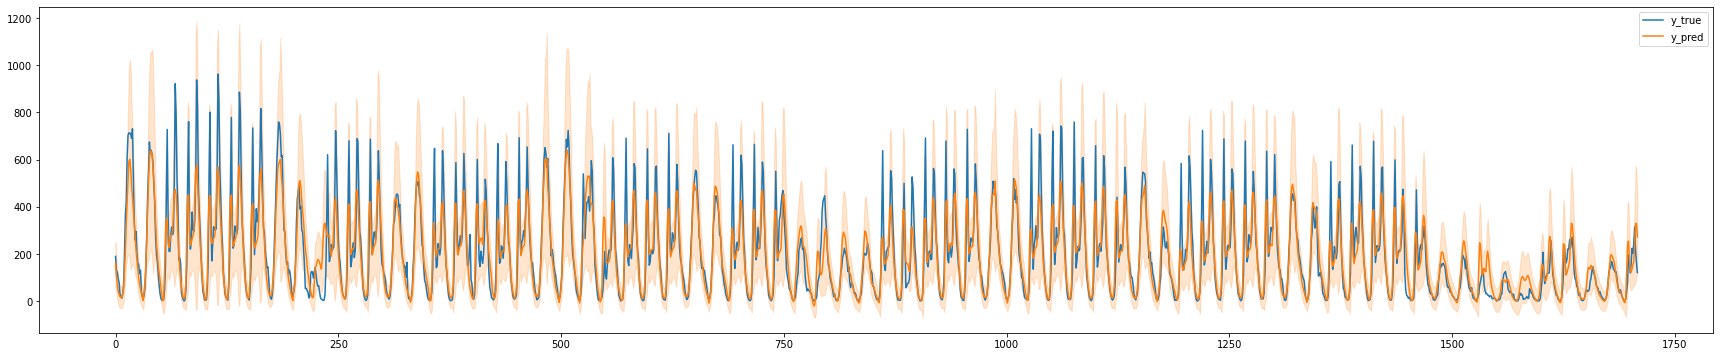

In [15]:
pred_plot(pred_idx=0)

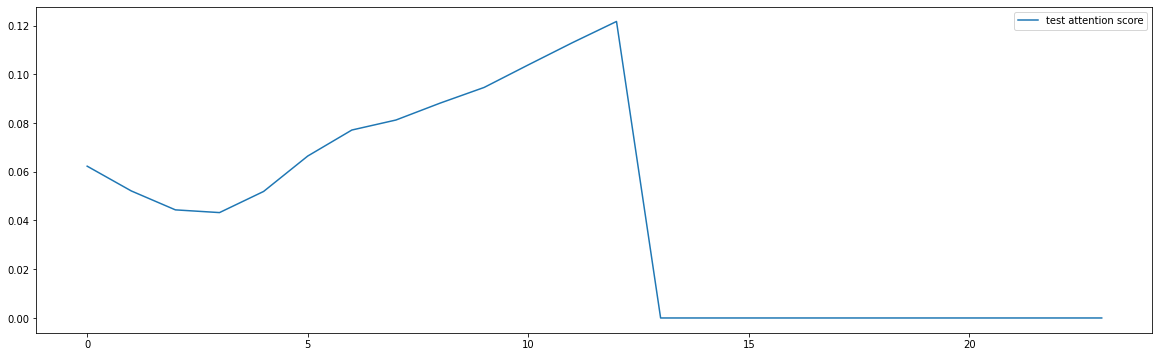

In [16]:
attention_plot(test_idx=-1, window_idx=12)